In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import os
import pickle
from multiprocessing import Process
import random
from feature_selection import feature_ranking_algorithm
import time

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
data_path = "D:/work/fsorfl/Final A(1)/Final A/code_report/code/RFLFSODataFull.csv"
root_dir = "D:/work/fsorfl/Final A(1)/Final A/code_report/code/"
original_data = pd.read_csv(data_path)
original_data.head()

processed_data = original_data.copy()

# Time: directly convert to category type
processed_data['Time'] = processed_data['Time'].astype('category')

# SYNOPCode: directly convert to category type
processed_data['SYNOPCode'] = processed_data['SYNOPCode'].astype('category')

# Frequency: convert to GHz unit
processed_data['Frequency'] = processed_data['Frequency'] / 1e9


# prepare feature set (remove target variables)
feature_cols = [col for col in processed_data.columns 
               if col not in ['FSO_Att', 'RFL_Att']]

In [3]:
def plot_feature_selection_results(results_df, title, divide_feature, save_path=None):
    """
    plot the feature selection process
    
    Parameters:
    -----------
    results_df : DataFrame
        the dataframe containing the feature selection results
    title : str
        the title of the image
    save_path : str, optional
        if provided, save the image to the specified path
    """
    fig, ax1 = plt.subplots(figsize=(15, 10))
    ax2 = ax1.twinx()

    # plot RMSE (blue line, left axis)
    line1 = ax1.plot(range(len(results_df)), 
                     results_df['oob_rmse'], 
                     color='blue', 
                     marker='o', 
                     label='RMSE')
    ax1.set_xlabel('Removed Features')
    ax1.set_ylabel('RMSE', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.grid(True, linestyle='--', alpha=0.7)

    # plot R² (red line, right axis)
    line2 = ax2.plot(range(len(results_df)), 
                     results_df['oob_r2'], 
                     color='red', 
                     marker='o', 
                     label='R²')
    ax2.set_ylabel('R² Score', color='red')
    ax2.tick_params(axis='y', labelcolor='red')


    ax1.set_xticks(range(len(results_df)))
    ax1.set_xticklabels(results_df['removed_feature'], rotation=90, ha='center')

    # find the position of Time and add a vertical line
    time_idx = results_df[results_df['removed_feature'] == divide_feature].index[0]
    ax1.axvline(x=time_idx - 0.5,  # subtract 0.5 from x value !!
                color='green', 
                linestyle='--',
                linewidth=2,
                alpha=0.8,
                label='Time Position')

    lines = line1 + line2 + [ax1.get_lines()[-1]]
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='upper left')

    plt.title(title)
    plt.subplots_adjust(bottom=0.3)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
    plt.show()





def load_and_plot_single_result(target_type, synop_code, divide_feature, method='method1'):
    """
    load and plot the feature selection results for a single SYNOP group
    
    Parameters:
    -----------
    target_type : str
        'RFL' 或 'FSO'
    synop_code : str or int
        the code of the SYNOP group
    """
    # result directory and file
    result_dir = f'results_{target_type.lower()}'
    result_file = f'synop_{synop_code}_results.pkl'
    
    # load results
    with open(os.path.join(result_dir, result_file), 'rb') as f:
        results_df = pickle.load(f)

    results_df = results_df.sort_index()
    # print(results_df)
    
    # create image title
    title = f'Feature Selection Results for SYNOP {synop_code} ({target_type})'
    
    save_path = os.path.join(result_dir, f'{target_type.lower()}_{method}_{synop_code}.png')
    
    plot_feature_selection_results(results_df, title, divide_feature, save_path)

    features_at_divide = results_df.loc[results_df['removed_feature'] == divide_feature, 'features'].values[0]

    
    return features_at_divide

def load_and_plot_method3_result(target_type, divide_feature,synop_code=None):
    """
    load and plot the feature selection results for a single SYNOP group
    
    Parameters:
    -----------
    target_type : str
        'RFL' or 'FSO'
    synop_code : str or int
        the code of the SYNOP group
    """
    # result directory and file
    result_dir = f'method3'
    if synop_code is None:
        result_file = f'results_{target_type.lower()}_method3.pkl'
    else:
        result_file = f'results_{target_type.lower()}_method3_sy{synop_code}.pkl'

    with open(os.path.join(result_dir, result_file), 'rb') as f:
        results_df = pickle.load(f)

    results_df = results_df.sort_index()
    # print(results_df)
    

    title = f'Feature Selection Results for {target_type} Method 3 ({divide_feature})'
    

    save_path = os.path.join(result_dir, f'{target_type}_method3_plot.png')
    

    plot_feature_selection_results(results_df, title, divide_feature, save_path)

    features_at_divide = results_df.loc[results_df['removed_feature'] == divide_feature, 'features'].values[0]

    
    return features_at_divide

def gene_final_X_y(important_features, target_type, synop_code=None):
    if synop_code is None:
        # actually, method2
        group_data = processed_data
    else:
        # actually, method1
        group_data = processed_data[processed_data['SYNOPCode'] == synop_code]
    
    X = group_data[important_features]
    y = group_data[target_type]
    return X, y

from sklearn.metrics import make_scorer
def tune_random_forest(X, y, param_grid=None, cv=5, verbose=True):
    """
    tune the hyperparameters of the random forest model
    
    Parameters:
    -----------
    X : feature data
    y : target variable
    param_grid : hyperparameter grid, if None, use the default grid
    cv : number of cross-validation folds
    verbose : whether to print detailed information
    
    Returns:
    --------
    dict : a dictionary containing the best model and performance metrics
    """
    # if param_grid is None, use the default grid
    if param_grid is None:
        param_grid = {
            'n_estimators': [100, 150],
            'max_depth': [None, 10, 20]
        }
    
    if verbose:
        print("Start tuning...")
        print(f"Dataset size: {X.shape}")
        print("Parameter grid:", param_grid)
        print("\n" + "-"*80)
        print(f"{'n_estimators':>12} | {'max_depth':>9} | {'OOB Score':>9} | {'OOB R²':>9} | {'OOB RMSE':>9}")
        print("-"*80)

    results = []


    # nested loop to iterate through all parameter combinations
    for n_trees in param_grid['n_estimators']:
        for max_depth in param_grid['max_depth']:
            # train model
            rf = RandomForestRegressor(
                n_estimators=n_trees,
                max_depth=max_depth,
                random_state=42,
                oob_score=True,
                n_jobs=-1
            )
            rf.fit(X, y)
            
            # get OOB prediction and scores
            oob_score = rf.oob_score_
            y_pred = rf.oob_prediction_
            r2 = r2_score(y, y_pred)
            rmse = np.sqrt(mean_squared_error(y, y_pred))
            
            results.append({
                'n_estimators': n_trees,
                'max_depth': max_depth,
                'oob_score': oob_score,
                'r2': r2,
                'rmse': rmse,
                'model': rf
            })
            
            if verbose:
                print(f"{n_trees:>12} | {str(max_depth):>9} | {oob_score:>9.6f} | {r2:>9.6f} | {rmse:>9.6f}")
    

    best_result = max(results, key=lambda x: x['oob_score'])

    if verbose:
        print("\nBest result:")
        print(f"Best parameters: n_estimators={best_result['n_estimators']}, max_depth={best_result['max_depth']}")
        print(f"Best OOB Score: {best_result['oob_score']:.6f}")
        print(f"Best OOB R² Score: {best_result['r2']:.6f}")
        print(f"Best OOB RMSE: {best_result['rmse']:.6f}")
    
    return {
        'best_params': {
            'n_estimators': best_result['n_estimators'],
            'max_depth': best_result['max_depth']
        },
        'best_oob_score': best_result['oob_score'],
        'final_model': best_result['model'],
        'oob_r2_score': best_result['r2'],
        'oob_rmse': best_result['rmse'],
        'results': results
    }



In [8]:
important_features_rfl_method1_synop = {
    0: ['AbsoluteHumidity', 'AbsoluteHumidityMax', 'AbsoluteHumidityMin', 'Distance', 'Frequency', 'Temperature', 'Time', 'Visibility', 'VisibilityMin'],
    3: ['AbsoluteHumidity', 'AbsoluteHumidityMax', 'AbsoluteHumidityMin', 'Frequency', 'RelativeHumidity', 'Temperature', 'TemperatureDifference', 'TemperatureMax', 'TemperatureMin', 'Time','Visibility'],
    4:['AbsoluteHumidityMin', 'RainIntensityMin', 'RelativeHumidity'],
    5:['AbsoluteHumidity', 'AbsoluteHumidityMax', 'AbsoluteHumidityMin', 'Distance', 'Frequency', 'RainIntensity', 'RainIntensityMax', 'RainIntensityMin', 'RelativeHumidity', 'Visibility'],
    6:['AbsoluteHumidity', 'AbsoluteHumidityMax', 'Distance', 'ParticulateMin', 'RainIntensity', 'RainIntensityMax', 'RainIntensityMin', 'RelativeHumidity', 'Temperature', 'TemperatureDifference', 'Visibility', 'VisibilityMax'],
    7:['AbsoluteHumidity', 'AbsoluteHumidityMax', 'Frequency', 'ParticulateMin', 'RainIntensity', 'RainIntensityMax', 'RainIntensityMin', 'RelativeHumidity', 'Temperature', 'TemperatureDifference', 'Time', 'VisibilityMin', 'WindSpeedMax'],
    8:['AbsoluteHumidity', 'AbsoluteHumidityMax', 'AbsoluteHumidityMin', 'Distance', 'Frequency', 'Particulate', 'ParticulateMax', 'ParticulateMin', 'RainIntensity', 'RainIntensityMax', 'RainIntensityMin', 'Temperature', 'TemperatureDifference', 'Visibility', 'VisibilityMax', 'VisibilityMin']
}

In [4]:
important_features_fso_method3_synop = {}

In [6]:
for sy in [6,8]:
    X_fso_method3_sy7 = processed_data[processed_data['SYNOPCode'] == sy][feature_cols+['RFL_Att']]
    y_fso_method3_sy7 = processed_data[processed_data['SYNOPCode'] == sy]['FSO_Att']
    results_fso_method3_sy7 = feature_ranking_algorithm(X_fso_method3_sy7, y_fso_method3_sy7, n_jobs=-1)
    # save results_rfl_method2 to pickle
    with open('method3/results_fso_method3_sy{}.pkl'.format(sy), 'wb') as f:
        pickle.dump(results_fso_method3_sy7, f)

1/26
2/26
3/26
4/26
5/26
6/26
7/26
8/26
9/26
10/26
11/26
12/26
13/26
14/26
15/26
16/26
17/26
18/26
19/26
20/26
21/26
22/26
23/26
24/26
25/26
26/26
1/26
2/26
3/26
4/26
5/26
6/26
7/26
8/26
9/26
10/26
11/26
12/26
13/26
14/26
15/26
16/26
17/26
18/26
19/26
20/26
21/26
22/26
23/26
24/26
25/26
26/26


In [26]:
sy = 5
X_fso_method3_sy7 = processed_data[processed_data['SYNOPCode'] == sy][feature_cols+['RFL_Att']]
y_fso_method3_sy7 = processed_data[processed_data['SYNOPCode'] == sy]['FSO_Att']
results_fso_method3_sy7 = feature_ranking_algorithm(X_fso_method3_sy7, y_fso_method3_sy7, n_jobs=-1)
# save results_rfl_method2 to pickle
with open('method3/results_fso_method3_sy{}.pkl'.format(sy), 'wb') as f:
    pickle.dump(results_fso_method3_sy7, f)

1/26
2/26
3/26
4/26
5/26
6/26
7/26
8/26
9/26
10/26
11/26
12/26
13/26
14/26
15/26
16/26
17/26
18/26
19/26
20/26
21/26
22/26
23/26
24/26
25/26
26/26


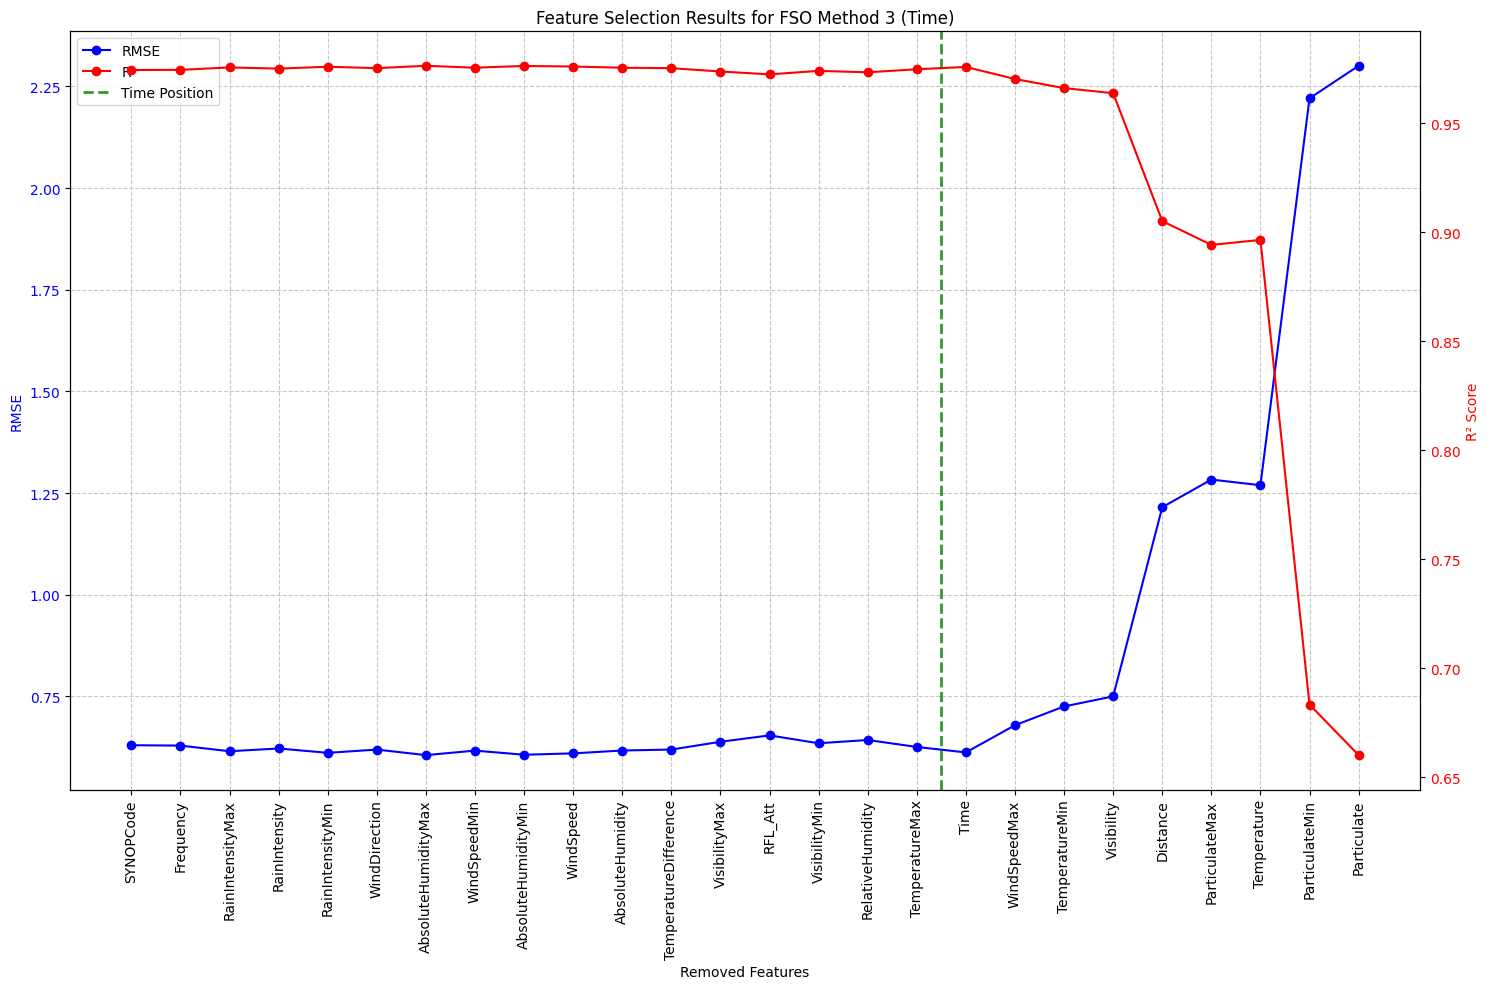

In [24]:
important_features_fso_method3_tmp = load_and_plot_method3_result('FSO', 'Time',sy)

In [25]:
important_features_fso_method3_synop[sy] = important_features_fso_method3_tmp

In [ ]:
for synop_code in processed_data['SYNOPCode'].unique():
    X_fso_method3_sy = processed_data[processed_data['SYNOPCode'] == synop_code][feature_cols+['RFL_Att']]
    y_fso_method3_sy = processed_data[processed_data['SYNOPCode'] == synop_code]['FSO_Att']

    train_idx, test_idx = train_test_split(processed_data[processed_data['SYNOPCode'] == synop_code].index, test_size=0.2)
    important_features_rfl_method1_synop_i = important_features_rfl_method1_synop[synop_code]

    #train test split
    X_rfl_method1_sy, y_rfl_method1_sy = gene_final_X_y(important_features_rfl_method1_synop_i, 'RFL_Att',7)
    x_train_rfl_method1_sy, y_train_rfl_method1_sy = X_rfl_method1_sy.loc[train_idx], y_rfl_method1_sy.loc[train_idx]
    x_test_rfl_method1_sy, y_test_rfl_method1_sy = X_rfl_method1_sy.loc[test_idx], y_rfl_method1_sy.loc[test_idx]

    rfl_method1_sy7_tune = tune_random_forest(
        x_train_rfl_method1_sy, 
        y_train_rfl_method1_sy,
        cv=5,
        verbose=True
    )

    rfl_method1_sy7_best_model = rfl_method1_sy7_tune['final_model']
    y_pred_rfl_method1_sy7 = rfl_method1_sy7_best_model.predict(x_test_rfl_method1_sy)

    